In [1]:
!pip install caer canaro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.5/809.5 kB 11.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 94.3 MB/s eta 0:00:00:00:0100:01


In [23]:
import os
import numpy as np
import caer
import canaro
import cv2 as cv
import gc
import matplotlib.pyplot as plt

In [8]:
IMG_SIZE = (80, 80)
channels = 1
char_path = r"../input/the-simpsons-characters-dataset/simpsons_dataset"

In [13]:
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path, char)))
char_dict = caer.sort_dict(char_dict, descending=True)

In [14]:
print(char_dict)

[('homer_simpson', 2246), ('ned_flanders', 1454), ('moe_szyslak', 1452), ('lisa_simpson', 1354), ('bart_simpson', 1342), ('marge_simpson', 1291), ('krusty_the_clown', 1206), ('principal_skinner', 1194), ('charles_montgomery_burns', 1193), ('milhouse_van_houten', 1079), ('chief_wiggum', 986), ('abraham_grampa_simpson', 913), ('sideshow_bob', 877), ('apu_nahasapeemapetilon', 623), ('kent_brockman', 498), ('comic_book_guy', 469), ('edna_krabappel', 457), ('nelson_muntz', 358), ('lenny_leonard', 310), ('mayor_quimby', 246), ('waylon_smithers', 181), ('maggie_simpson', 128), ('groundskeeper_willie', 121), ('barney_gumble', 106), ('selma_bouvier', 103), ('carl_carlson', 98), ('ralph_wiggum', 89), ('patty_bouvier', 72), ('martin_prince', 71), ('professor_john_frink', 65), ('snake_jailbird', 55), ('cletus_spuckler', 47), ('rainier_wolfcastle', 45), ('simpsons_dataset', 42), ('agnes_skinner', 42), ('sideshow_mel', 40), ('otto_mann', 32), ('fat_tony', 27), ('gil', 27), ('miss_hoover', 17), ('dis

In [16]:
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break

In [17]:
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [20]:
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 1.7384521961212158s
[INFO] At 1000 files
[INFO] 1454 files found in 1.1854562759399414s
[INFO] At 1000 files
[INFO] 1452 files found in 1.206298589706421s
[INFO] At 1000 files
[INFO] 1354 files found in 1.223442554473877s
[INFO] At 1000 files
[INFO] 1342 files found in 1.191938877105713s
[INFO] At 1000 files
[INFO] 1291 files found in 1.0410094261169434s
[INFO] At 1000 files
[INFO] 1206 files found in 1.0612382888793945s
[INFO] At 1000 files
[INFO] 1194 files found in 1.057178020477295s
[INFO] At 1000 files
[INFO] 1193 files found in 1.0730359554290771s
[INFO] At 1000 files
[INFO] 1079 files found in 1.0566868782043457s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 0m 59s


In [21]:
len(train)

13811

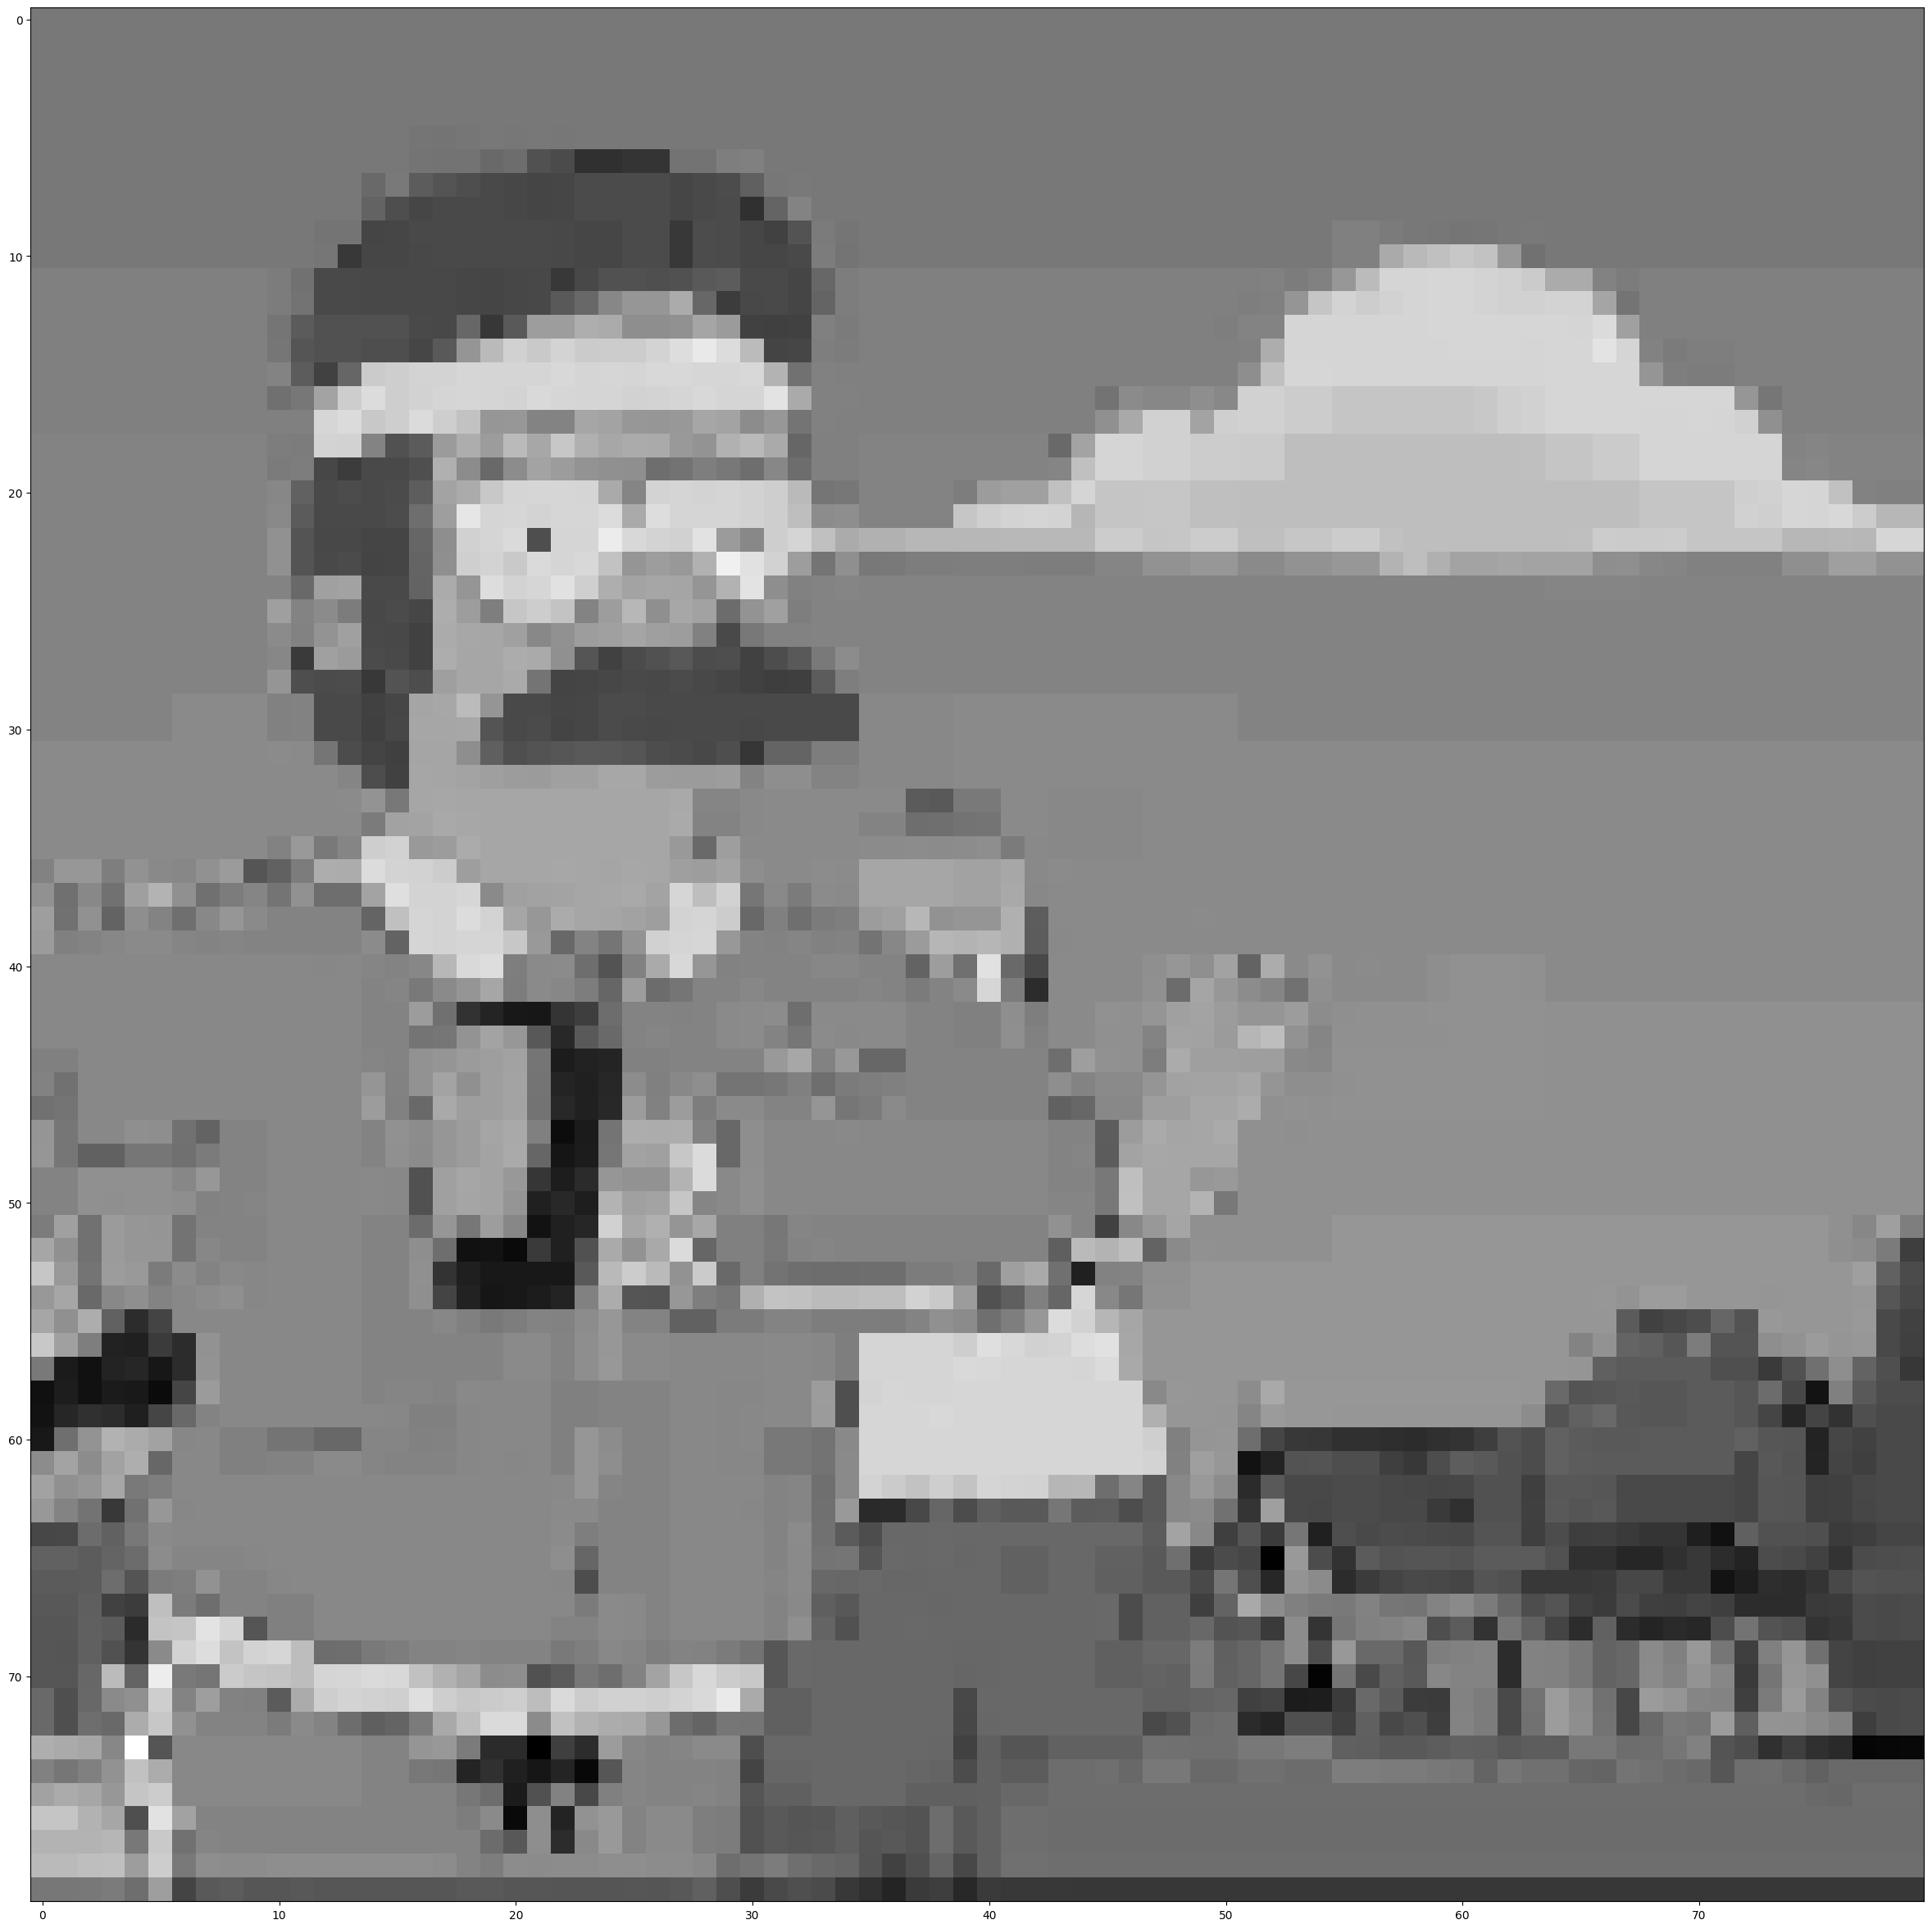

In [31]:
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [33]:
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [34]:
from tensorflow.keras.utils import to_categorical
featureSet = caer.normalize(featureSet)
labels = to_categorical(labels, len(characters))

In [36]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=.2)

In [37]:
del train
del featureSet
del labels
gc.collect()

0

In [38]:
BATCH_SIZE = 32
EPOCHS = 10

In [41]:
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

output_dim=10

w, h = IMG_SIZE[:2]

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(w, h,channels)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))

# Output Layer
model.add(Dense(output_dim, activation='softmax'))

In [45]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 80, 80, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 78, 78, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 39, 39, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 39, 39, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 39, 39, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 18, 18, 256)         │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │      16,778,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,591,274 (67.11 MB)

 Trainable params: 17,591,274 (67.11 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
from tensorflow.keras.optimizers import SGD

optimizer = SGD(learning_rate=0.001, decay=1e-7, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [49]:
from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]
training = model.fit(train_gen,
                    steps_per_epoch=len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


345/345 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.1389 - loss: 0.3883 - val_accuracy: 0.1610 - val_loss: 0.3301 - learning_rate: 0.0100
Epoch 2/10
  1/345 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.1875 - loss: 0.3219

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1875 - loss: 0.3219 - val_accuracy: 0.1610 - val_loss: 0.3301 - learning_rate: 0.0100
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.1596 - loss: 0.3237 - val_accuracy: 0.1610 - val_loss: 0.3298 - learning_rate: 0.0100
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1250 - loss: 0.3266 - val_accuracy: 0.1610 - val_loss: 0.3299 - learning_rate: 0.0100
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.1645 - loss: 0.3232 - val_accuracy: 0.1610 - val_loss: 0.3310 - learning_rate: 0.0100
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2188 - loss: 0.3195 - val_accuracy: 0.1610 - val_loss: 0.3309 - learning_rate: 0.0100
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.1592 - loss: 0.3228 - val_accuracy: 0.1610 - val_loss: 0.3265 - learning_rate: 0.0100
Epoch 8/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1875 - loss: 0.3133 - val_accu

In [50]:
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

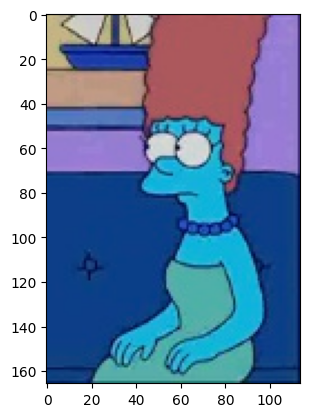

In [67]:
test_path = r'../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/marge_simpson_2.jpg'

img = cv.imread(test_path)

plt.imshow(img)
plt.show()

In [56]:
def prepare(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, IMG_SIZE)
    image = caer.reshape(image, IMG_SIZE, 1)
    return image

In [68]:
predictions = model.predict(prepare(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [70]:
# Getting class with the highest probability
print(characters[np.argmax(predictions[0])])

lisa_simpson
